# Multi-Layer Perceptron (MLP), MNIST
---
<font color='cyan'> Responsible TA: AmirHossein Razlighi </font>

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

This is a well-known and famous problem in the machine learning community! We try to train our network to recognize handwritten digits from 0 to 9. We use the famous MNIST dataset for this purpose. The dataset contains 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image. We will use the MLP to classify the images.

Let's proceed with the excersise!

In [20]:
# Run this code if you are trying to run the notebook locally
!python3 -m venv ./venv
!source ./venv/bin/activate

In [21]:
%pip install torch torchvision numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In this cell we first, download the dataset (using torch datasets) and then, create the test_set and train_sets to use in the rest of our notebook.
You can also change the `batch_size` in this cell to your desired amount.

In [23]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

## See some of the training images

First thing to do in any machine learning task is to look at your data! load a batch of images from the training set and display them in a grid using the `imshow` function from `matplotlib.pyplot`. You can also use `torchvision.utils.make_grid` to create a grid from a list of images (batch).

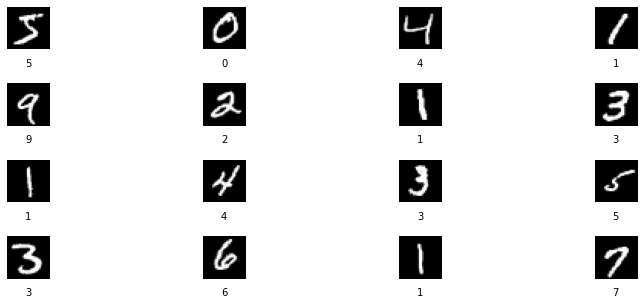

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dataiter = iter(train_loader)
images, labels = next(dataiter)

grid_size = int(np.sqrt(images.shape[0]))
fig, ax = plt.subplots(grid_size, grid_size, figsize=(14, 5))

for i in range(grid_size):
    for j in range(grid_size):
        ax[i, j].imshow(images[i * grid_size + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].text(0.5, -0.4, str(labels[i * grid_size + j].item()), 
                      size=10, ha='center', transform=ax[i, j].transAxes)

plt.subplots_adjust(wspace=0.01, hspace=0.8)
plt.show()

## View an Image in More Detail

Here, we look at one sample in a batch to see the pixel values (intensities). Note that our images are grayscale (even if the dataset were in RGB, the color data was irrelevant!) because for detecting the handwritten digits, the color of the ink of pen is not important (obviously)!

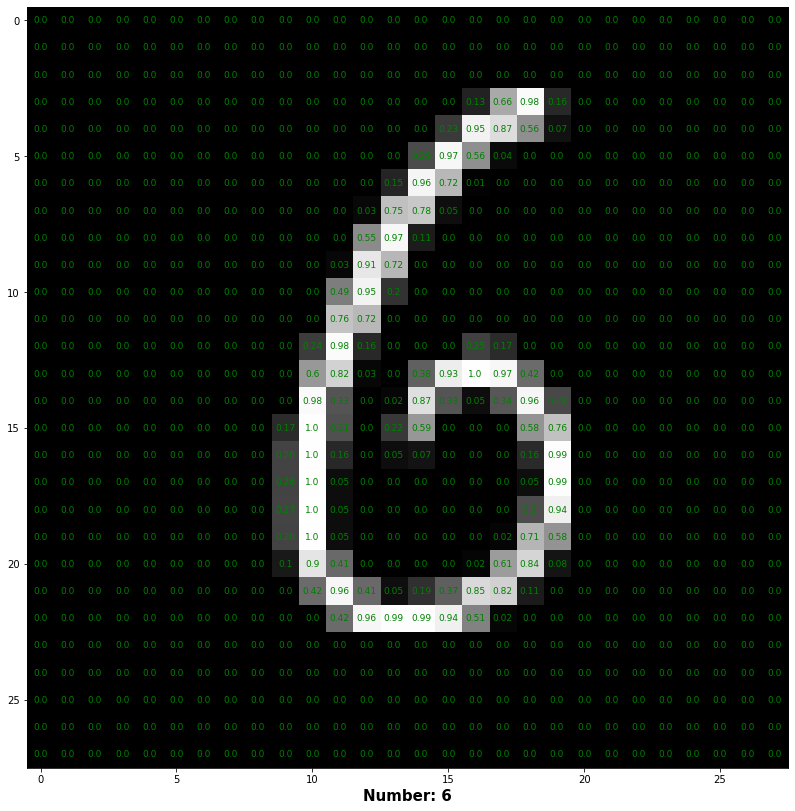

In [28]:
import matplotlib.pyplot as plt
import random

dataiter = iter(train_loader)
images, labels = next(dataiter)
random_index = random.randint(0, len(images) - 1)

image = images[random_index]
label = labels[random_index]

image_np = image.numpy()
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

ax.imshow(image_np[0], cmap='gray')

for i in range(28):
    for j in range(28):
        intensity = round(image_np[0, i, j], 2)
        ax.text(j, i, str(intensity), ha='center', va='center', color='green', fontsize=9)

ax.axis('on')
ax.set_xlabel(f'Number: {label.item()}', fontsize=15, fontweight='bold')
plt.show()


---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In this cell, you should define the network architecture. Note the dimensions of the input (print it out!) and the outputs. Your output should be a tensor of length 10 (digits 0 to 9) that indicates scores (probabilities) for an input image belonging to that class [$P(C_i|x)$]. Use `Drop out` layers to avoid overfitting!

In [29]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


##  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Here you should define the loss function used in training process and the optimizer. We recommend you use `cross-entropy` loss. But you can explore other loss functions if you think they work better in this case! Also, you can use `SGD` or `Adam` optimizer, or any other optimizers that you think would work better!

In [30]:
import torch.optim as optim

# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Complete the code below:

In [32]:
from tqdm import tqdm

n_epochs = 35
train_losses = []
for epoch in range(n_epochs):
    train_loss = 0.0
    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}', leave=False)
    for data, target in progress_bar:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        progress_bar.set_postfix({'Training Loss': loss.item()})
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    progress_bar.set_postfix({'Training Loss': train_loss})
    progress_bar.close()
    print(f'\rEpoch: {epoch+1}/{n_epochs}\tTraining Loss: {train_loss:.6f}', end='')

Epoch: 1/35	Training Loss: 0.024032

Epoch: 2/35	Training Loss: 0.026520

Epoch: 3/35	Training Loss: 0.031317

Epoch: 4/35	Training Loss: 0.025736

Epoch: 5/35	Training Loss: 0.026473

Epoch: 6/35	Training Loss: 0.031236

Epoch: 7/35	Training Loss: 0.027365

Epoch: 8/35	Training Loss: 0.033891

Epoch: 9/35	Training Loss: 0.023239

Epoch: 10/35	Training Loss: 0.027501

Epoch: 11/35	Training Loss: 0.026543

Epoch: 12/35	Training Loss: 0.025542

Epoch: 13/35	Training Loss: 0.024057

Epoch: 14/35	Training Loss: 0.027305

Epoch: 15/35	Training Loss: 0.031267

Epoch: 16/35	Training Loss: 0.025697

Epoch: 17/35	Training Loss: 0.025403

Epoch: 18/35	Training Loss: 0.024193

Epoch: 19/35	Training Loss: 0.025900

Epoch: 20/35	Training Loss: 0.026276

Epoch: 21/35	Training Loss: 0.028745

Epoch: 22/35	Training Loss: 0.026196

Epoch: 23/35	Training Loss: 0.020536

Epoch: 24/35	Training Loss: 0.028237

Epoch: 25/35	Training Loss: 0.028858

Epoch: 26/35	Training Loss: 0.023200

Epoch: 27/35	Training Loss: 0.027086

Epoch: 28/35	Training Loss: 0.025430

Epoch: 29/35	Training Loss: 0.028255

Epoch: 30/35	Training Loss: 0.022923

Epoch: 31/35	Training Loss: 0.028474

Epoch: 32/35	Training Loss: 0.026650

Epoch: 33/35	Training Loss: 0.023599

Epoch: 34/35	Training Loss: 0.021607

Epoch: 35/35	Training Loss: 0.024656

---
## Test the Trained Network

And at last, you should test the model on test_set (previously unseen data). We will use test_set to evaluate the model's performance. Don't forget to prepare the model for evaluation(testing) using `model.eval()` in Pytorch!

You should report the Test Accuracy of your model.

In [36]:
model.eval()

test_loss = 0.0
correct = 0
for images, labels in test_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)
    _ , predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100.0 * correct / len(test_loader.dataset)
print('Test Loss: {:.6f}'.format(test_loss))

class_correct = list(0. for _ in range(10))
class_total = list(0. for _ in range(10))

for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Test Accuracy of {:5d}: {:.2f}% ({}/{})'.format(
        i, 100.0 * class_correct[i] / class_total[i], int(class_correct[i]), int(class_total[i])))

print('Test Accuracy (Overall): {:.2f}% ({}/{})'.format(
    test_accuracy, correct, len(test_loader.dataset)))

Test Loss: 0.270440
Test Accuracy of     0: 98.88% (969/980)
Test Accuracy of     1: 99.21% (1126/1135)
Test Accuracy of     2: 98.74% (1019/1032)
Test Accuracy of     3: 98.02% (990/1010)
Test Accuracy of     4: 97.45% (957/982)
Test Accuracy of     5: 99.10% (884/892)
Test Accuracy of     6: 98.43% (943/958)
Test Accuracy of     7: 98.54% (1013/1028)
Test Accuracy of     8: 98.46% (959/974)
Test Accuracy of     9: 97.72% (986/1009)
Test Accuracy (Overall): 98.46% (9846/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

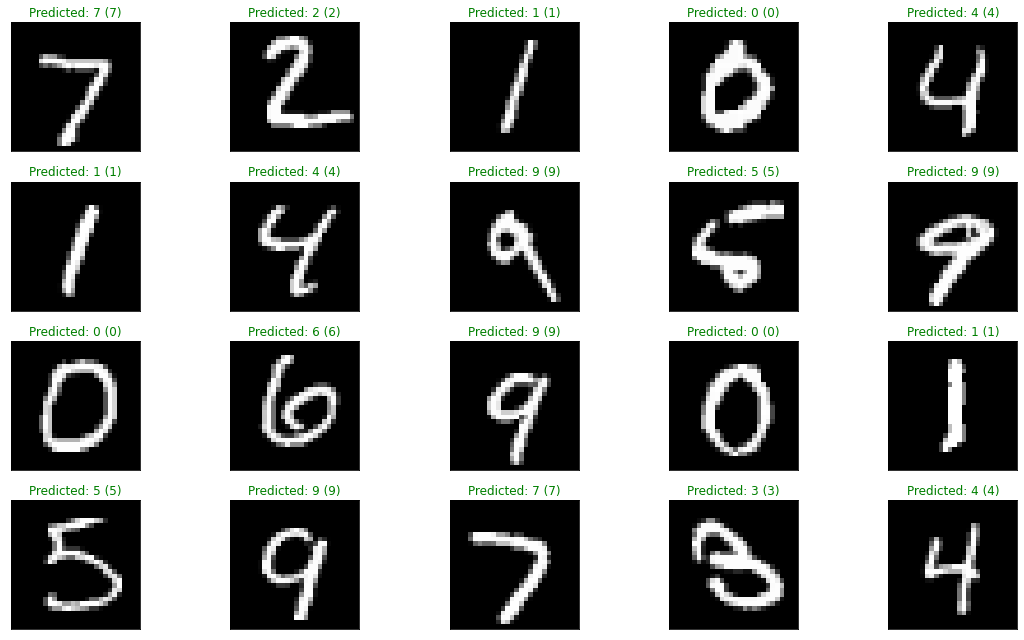

In [44]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(16, 9))

for idx in range(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze(), cmap='gray')
    color = 'green' if predicted[idx] == labels[idx] else 'red'
    ax.set_title('Predicted: {} ({})'.format(predicted[idx].item(), labels[idx].item()), color=color)

plt.tight_layout()
plt.show()